<font size="12">Exploring the datasets</font>

# Setting up

## Importing libraries

In [179]:
import pandas as pd
import pathlib
import keras
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from transformers import TFAutoModelForImageClassification, AutoImageProcessor

from sklearn.metrics import accuracy_score
from tensorflow.keras import layers, models, optimizers

from tensorflow.keras.applications import ResNet50, imagenet_utils
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications import DenseNet121

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, concatenate, UpSampling2D

## Importing data

In [206]:
url_normal = '../data/MR/knee/normal_filter/'

url_airspace = '../data/MR/knee/acl_pathology_filter/'
url_bronch = '../data/MR/knee/bone_inflammation_filter/'
url_inter = '../data/MR/knee/chondral_abnormality/'
url_nodule = '../data/MR/knee/fracture_filter/'
url_parenchyma = '../data/MR/knee/hematoma_filter/'

In [212]:
limite = 64

In [213]:
images_normal = [cv2.imread(file) for file in glob.glob(url_normal+"*.png")][:limite]

In [214]:
images_airspace = [cv2.imread(file) for file in glob.glob(url_airspace+"*.png")][:limite]
images_bronch = [cv2.imread(file) for file in glob.glob(url_bronch+"*.png")][:limite]
#images_inter = [cv2.imread(file) for file in glob.glob(url_inter+"*.png")][:limite]
images_nodule = [cv2.imread(file) for file in glob.glob(url_nodule+"*.png")][:limite]
images_parenchyma = [cv2.imread(file) for file in glob.glob(url_parenchyma+"*.png")][:limite]

In [215]:
#images_nodule = [cv2.imread(file) for file in glob.glob(url_nodule + "*.png")]
labels_airspace = [2] * len(images_nodule)
labels_bronch = [3] * len(images_nodule)
#labels_inter = [4] * len(images_nodule)
labels_nodule = [1] * len(images_nodule)
labels_parenchyma = [4] * len(images_nodule)

#images_normal = [cv2.imread(file) for file in glob.glob(url_normal + "*.png")]
labels_normal = [0] * len(images_normal)

## Checking data

In [216]:
normal_count = len(images_normal)
normal_count

64

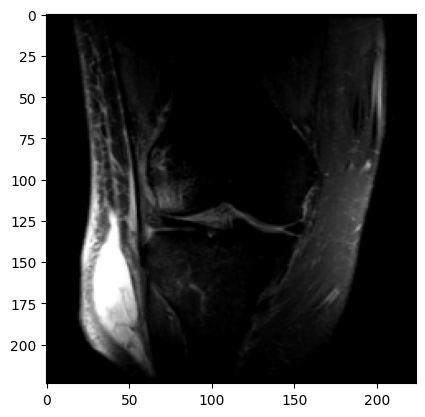

In [217]:
img = np.asarray(images_parenchyma[0])
imgplot = plt.imshow(img)

# Base Model definition

In [169]:
def initialize_model():

    model = models.Sequential()

    model.add(layers.Conv2D(16, (4,4), activation="relu", input_shape=(224, 224, 3)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(32, (3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(64, (3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(64, (2,2), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(32, activation='relu'))

    model.add(layers.Dense(4, activation='softmax'))
    
    ### Model compilation
    model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
       
    
    return model

# Trying different models and preparing data

In [280]:
X = np.concatenate((images_normal, images_nodule, images_airspace, images_bronch, images_parenchyma), axis=0)
y = np.concatenate((labels_normal, labels_nodule, labels_airspace, labels_bronch, labels_parenchyma), axis=0)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.5)

#base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))



for layer in base_model.layers:
    layer.trainable = False

x = layers.Flatten()(base_model.output)
x = layers.Dense(512, activation='relu')(x)

x = layers.Dense(64, activation='tanh')(x)

num_classes = 5
output_layer = layers.Dense(num_classes, activation='softmax')(x)

fine_tuned_model = models.Model(inputs=base_model.input, outputs=output_layer)

fine_tuned_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Creating X and y for training and testing

In [197]:
X = np.concatenate((images_nodule, images_normal, images_airspace, images_bronch), axis=0)
y = np.concatenate((labels_nodule, labels_normal, labels_airspace, labels_bronch), axis=0)

# , images_inter, images_parenchyma,
#, labels_inter, labels_parenchyma,

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [172]:
X_train.shape

(576, 224, 224, 3)

In [173]:
y_train.shape

(576,)

# Training the model

In [174]:
model = initialize_model()

In [175]:
es = EarlyStopping(patience = 5, restore_best_weights=True)

history = model.fit(preprocess_input(X_train), y_train, 
          epochs=20,
          batch_size=64,
          validation_data = 0.2,
          callbacks=[es],
          verbose=1)

Epoch 1/20
8/8 [==============================] - 9s 883ms/step - loss: 28.1257 - accuracy: 0.2239 - val_loss: 3.3132 - val_accuracy: 0.2586
Epoch 2/20
8/8 [==============================] - 7s 876ms/step - loss: 2.2950 - accuracy: 0.3804 - val_loss: 1.2757 - val_accuracy: 0.4052
Epoch 3/20
8/8 [==============================] - 7s 899ms/step - loss: 1.2935 - accuracy: 0.4196 - val_loss: 1.2874 - val_accuracy: 0.4397
Epoch 4/20
8/8 [==============================] - 7s 909ms/step - loss: 1.1925 - accuracy: 0.4587 - val_loss: 1.2435 - val_accuracy: 0.4828
Epoch 5/20
8/8 [==============================] - 8s 970ms/step - loss: 1.0676 - accuracy: 0.5413 - val_loss: 1.1607 - val_accuracy: 0.5086
Epoch 6/20
8/8 [==============================] - 8s 1s/step - loss: 0.9383 - accuracy: 0.6326 - val_loss: 1.1006 - val_accuracy: 0.5690
Epoch 7/20
8/8 [==============================] - 8s 1s/step - loss: 0.8045 - accuracy: 0.6543 - val_loss: 1.1059 - val_accuracy: 0.5603
Epoch 8/20
8/8 [=========

In [281]:
history = fine_tuned_model.fit(
    preprocess_input(X_train),
    y_train,
    epochs=6,
    validation_data=(preprocess_input(X_val), y_val)
)

test_results = fine_tuned_model.evaluate(preprocess_input(X_test), y_test)
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

Epoch 1/6
7/7 [==============================] - 40s 6s/step - loss: 1.8515 - accuracy: 0.2723 - val_loss: 1.4416 - val_accuracy: 0.4167
Epoch 2/6
7/7 [==============================] - 39s 6s/step - loss: 0.9362 - accuracy: 0.6875 - val_loss: 1.0545 - val_accuracy: 0.4792
Epoch 3/6
7/7 [==============================] - 38s 6s/step - loss: 0.6589 - accuracy: 0.8304 - val_loss: 0.9667 - val_accuracy: 0.6458
Epoch 4/6
7/7 [==============================] - 38s 6s/step - loss: 0.4703 - accuracy: 0.9107 - val_loss: 0.8367 - val_accuracy: 0.7292
Epoch 5/6
7/7 [==============================] - 38s 6s/step - loss: 0.3565 - accuracy: 0.9554 - val_loss: 0.8000 - val_accuracy: 0.7500
Epoch 6/6
2/2 [==============================] - 7s 2s/step - loss: 1.0090 - accuracy: 0.6042
Test Loss: 1.0089613199234009
Test Accuracy: 0.6041666865348816


# Testing the model and displaying results

In [200]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- ACCURACY
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    if title:
        fig.suptitle(title)

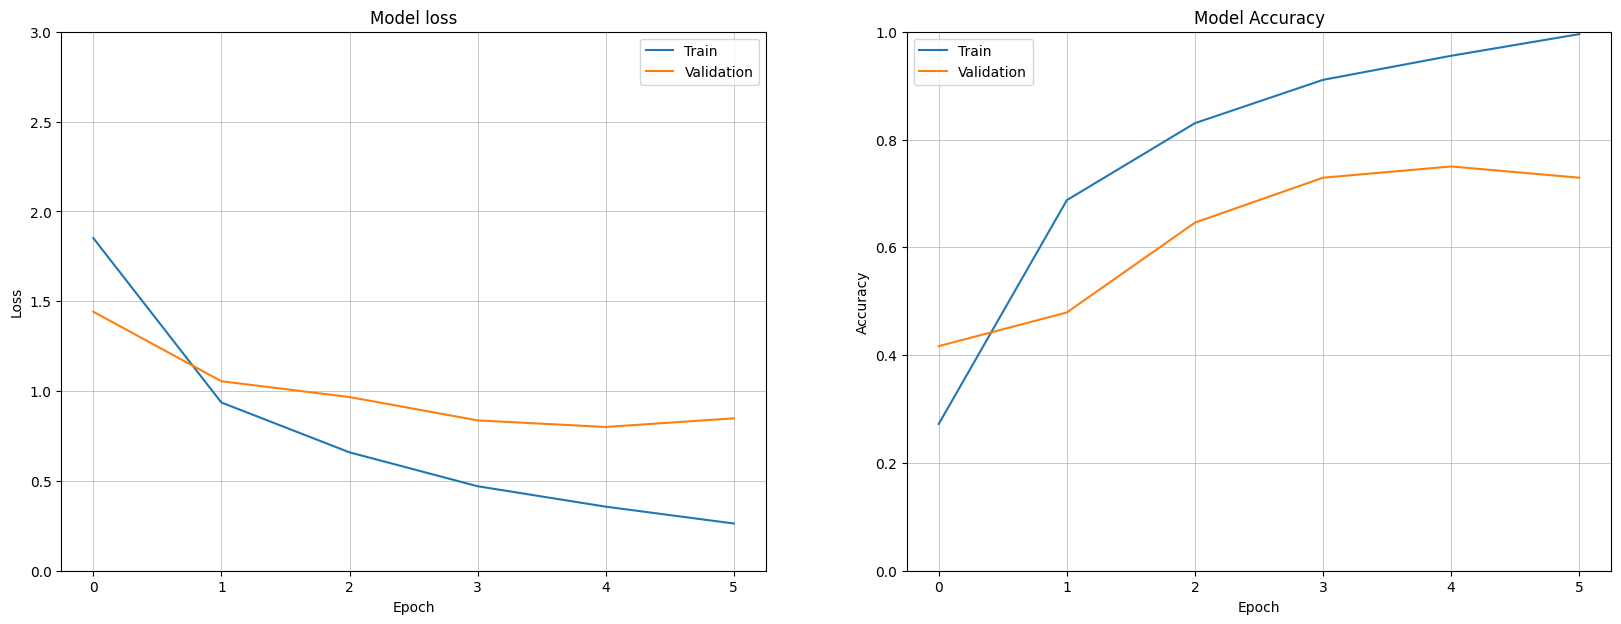

In [282]:
plot_loss_accuracy(history, title=None)

In [283]:
evaluation = fine_tuned_model.evaluate(preprocess_input(X_test), y_test)

2/2 [==============================] - 6s 2s/step - loss: 1.0090 - accuracy: 0.6042


In [284]:
print(f'Model accuracy is {round(evaluation[1]*100,2)} %')

Model accuracy is 60.42 %


# Getting layer names out and displaying GradCAM

In [289]:
#layer_names = ['input_5','bn_Conv1' 'Conv1_relu','block_1_expand_relu', 'block_2_expand_relu']
layer_names = ['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv1', 'block3_conv1']
#layer_names = ['conv1_conv', 'conv1_relu', 'conv2_block1_1_conv','conv2_block2_out', 'conv3_block1_1_conv']
#layer_names = ['input_6','conv1/conv','conv1/relu','conv2_block1_0_relu','conv2_block2_1_conv'] #DenseNet 121
#layer_names = ['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1'] #VGG + 512

layers_to_visualize = layer_names
number = 0

name = X_test[number]
test_image_array = np.asarray(name)

1/1 [==============================] - 1s 737ms/step


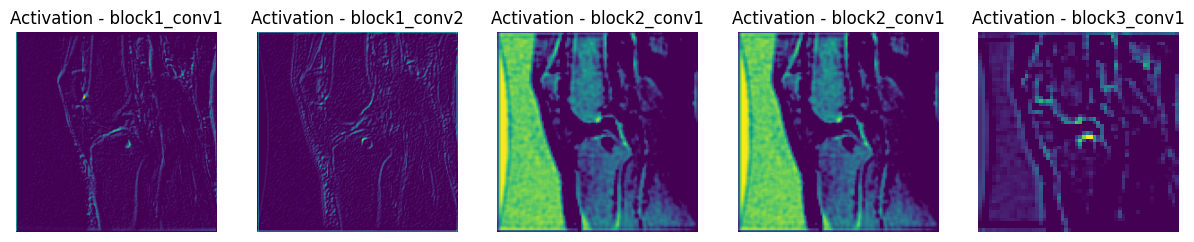

In [290]:
def visualize_activations(model, img_array, layers):

    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    outputs = [model.get_layer(layer).output for layer in layers]
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=outputs)

    activations = activation_model.predict(img_array)

    plt.figure(figsize=(15, 8))
    for i, activation in enumerate(activations):
        plt.subplot(1, len(layers), i + 1)
        plt.imshow(activation[0, :, :, 0], cmap='viridis')  # Adjust the indexing if needed
        plt.title(f'Activation - {layers[i]}')
        plt.axis('off')

    plt.show()

visualize_activations(fine_tuned_model, test_image_array, layers_to_visualize)

1/1 [==============================] - 0s 130ms/step
Predicted class: Airspaces
Confidence: 47.64%
4


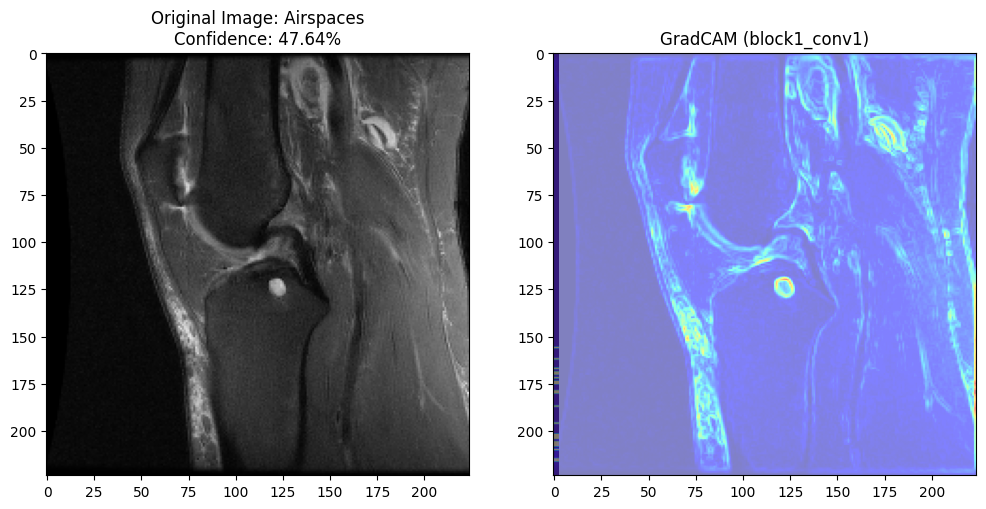

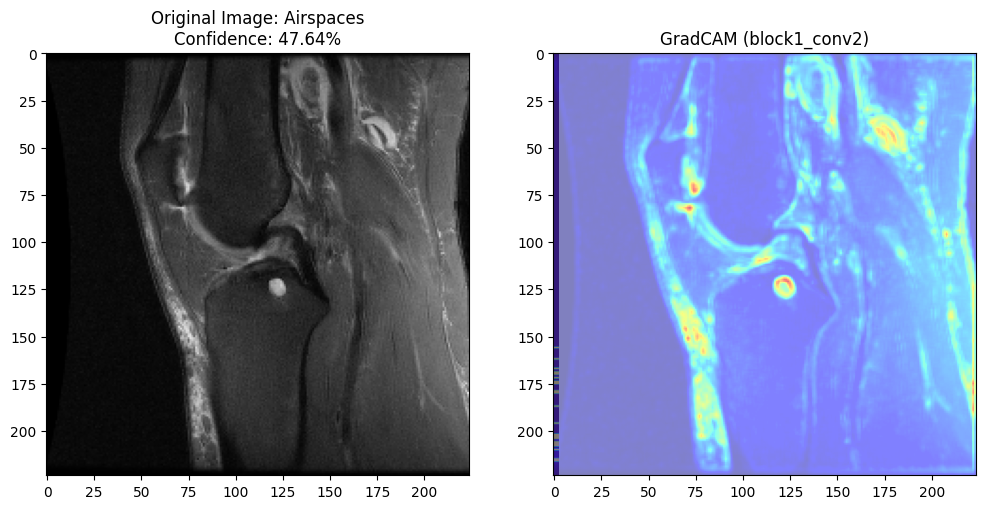

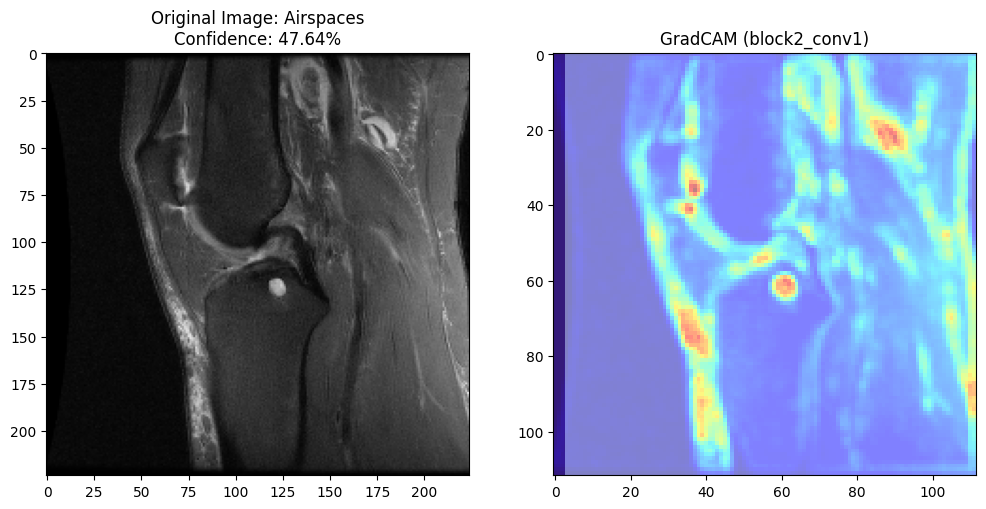

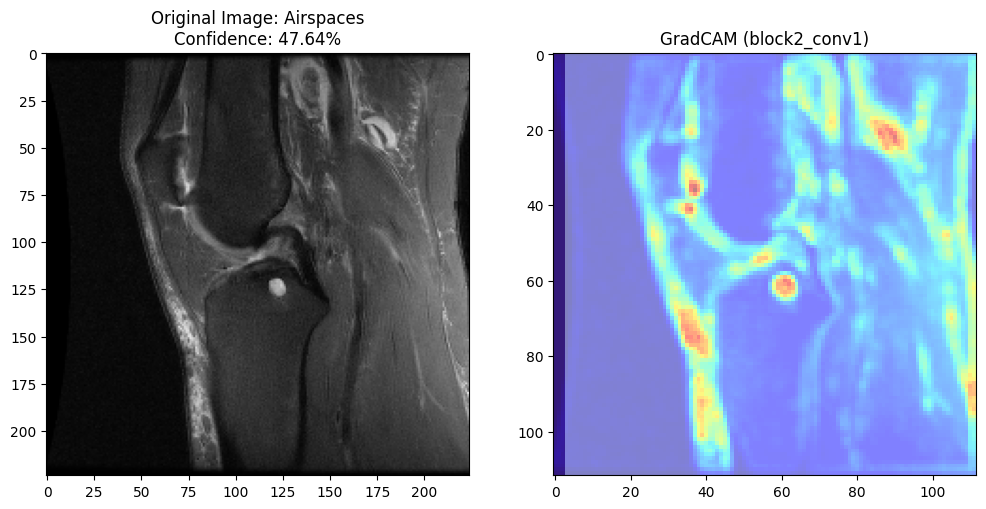

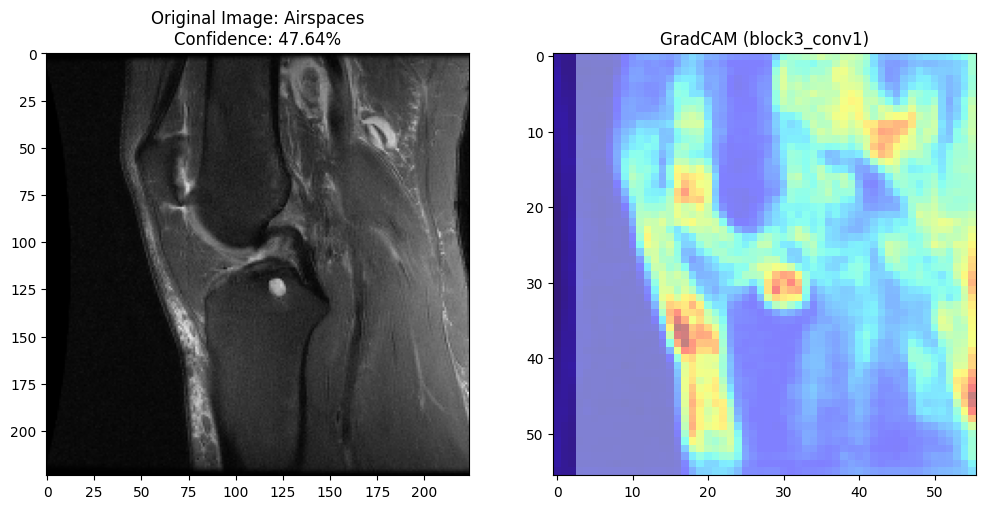

In [291]:
#Version 2 DenseNet 121
def generate_gradcam(model, img_array, layer_name):
    img_array = np.expand_dims(img_array, axis=0)
    grad_model = tf.keras.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        loss = predictions[:, 1]

    grads = tape.gradient(loss, conv_output)

    # Check if gradients are not None before proceeding
    if grads is None:
        print("Gradients are None. Skipping GradCAM computation.")
        return None, None, None

    guided_grads = (tf.cast(conv_output > 0, "float32") * tf.cast(grads > 0, "float32") * grads)

    weights = tf.reduce_mean(guided_grads, axis=(0, 1, 2))
    cam = np.dot(conv_output[0], weights)

    return cam, conv_output, predictions


def plot_gradcam(model, img_array, layer_name, label, confidence):
    cam, _, _ = generate_gradcam(model, img_array, layer_name)

    # Check if cam is None
    if cam is None:
        print("GradCAM is None. Skipping visualization.")
        return

    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_array)
    plt.title(f'Original Image: {label}\nConfidence: {confidence:.2%}')

    plt.subplot(1, 2, 2)
    plt.imshow(img_array[0], alpha=0.8)
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title(f'GradCAM ({layer_name})')

    plt.show()

predictions = fine_tuned_model.predict(preprocess_input(np.expand_dims(test_image_array, axis=0)))

predicted_class_index = np.argmax(predictions[0])
confidence = predictions[0][predicted_class_index]

class_labels = ["Normal", "Nodule", "Airspaces", "Bronch", "Parenchyma"]
predicted_label = class_labels[predicted_class_index]

print(f"Predicted class: {predicted_label}")
print(f"Confidence: {confidence:.2%}")

print(y_test[number])

for layer_name in layer_names:
    plot_gradcam(fine_tuned_model, test_image_array, layer_name, predicted_label, confidence)

In [288]:
y_test

array([4, 1, 1, 4, 1, 3, 0, 4, 1, 0, 2, 0, 1, 2, 1, 2, 4, 1, 3, 2, 3, 2,
       1, 1, 1, 0, 3, 4, 1, 2, 3, 4, 2, 2, 1, 3, 0, 1, 4, 4, 1, 2, 2, 0,
       0, 4, 3, 3])

(images_normal, images_nodule, images_airspace, images_bronch, images_parenchyma)

       0             1             2             3             4